# ***VAE for image generation***
Consider VAE model from
*Auto-Encoding Variational Bayes (2014, D.P. Kingma et. al.)*.  

We will implement a VAE model using Torch and apply it to the MNIST dataset.


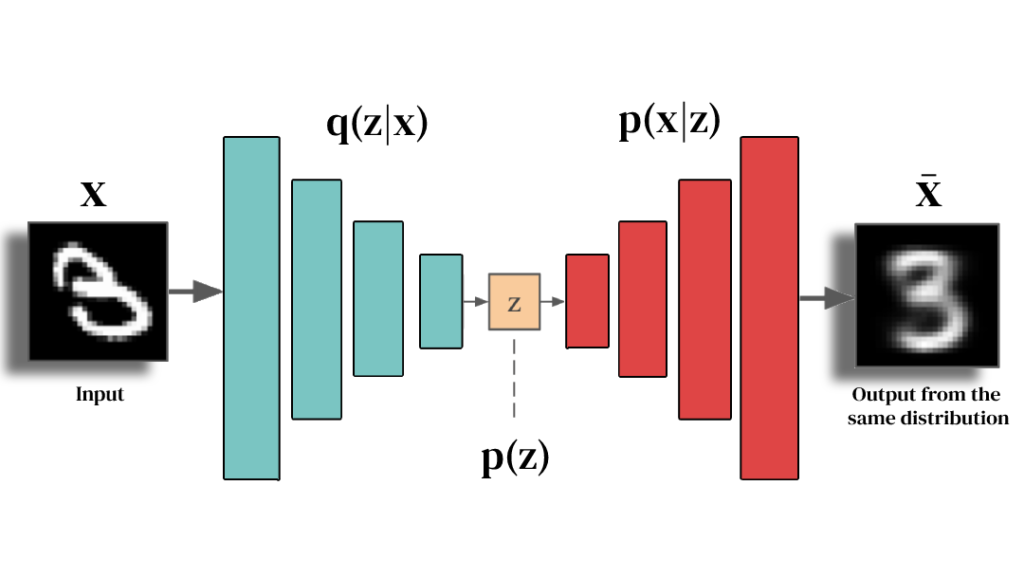


**Generative model:** We model each pixel value $\in \{0,1\}$ as a sample drawn from a Bernoulli distribution. Through a decoder, the latent random variable $z_n$  associated with an image $n$ is mapped to the success parameters of the Bernoulli distributions associated with the pixels of that image. Our generative model is described as follows:

$ z_n \sim N(0,I) $

$ \theta_n = g(z_n) $

$ x_n \sim Bern(\theta_n) $

where $g$ is the decoder. We choose the prior on $z_n$ to be the standard multivariate normal distribution, for computational convenience.  

**Inference model:** We infer the posterior distribution of $z_n$ via variational inference. The variational distribution $ q(z_n|x_n) $ is chosen to be multivariate Gaussian with a diagonal covariance matrix. The mean and covariance of this distribution are obtained by applying an encoder to $x_n$.

$ q(z_n|x_n) \sim q( \mu_n, \sigma^2_n) $

where $ \mu_n, \sigma^2_n = f(x_n)  $ and $f$ is the encoder.






**Implementation:**
Let's start with importing Torch and other necessary libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

### ***Step1: Model Hyperparameters***



In [2]:
dataset_path = '~/datasets'

batch_size = 100

# Dimensions of the input, the hidden layer, and the latent space.
x_dim  = 784
hidden_dim = 400
latent_dim = 200

# Learning rate
lr = 1e-3

# Number of epoch
epochs = 15 # can try something greater if you are not satisfied with the results

### ***Step2: Load Dataset***



In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

### ***Step3: Define the model***


In [4]:
class Encoder(nn.Module):
    # encoder outputs the parameters of variational distribution "q"
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_enc1 = nn.Linear(input_dim, hidden_dim) # FC stands for a fully connected layer
        self.FC_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var  = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # will use this to add non-linearity to our model

        self.training = True

    def forward(self, x):
        h_1     = self.LeakyReLU(self.FC_enc1(x))
        h_2     = self.LeakyReLU(self.FC_enc2(h_1))
        mean    = self.FC_mean(h_2)  # mean
        log_var = self.FC_var(h_2)   # log of variance

        return mean, log_var

In [5]:
class Decoder(nn.Module):
    # decoder generates the success parameter of each pixel
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_dec1   = nn.Linear(latent_dim, hidden_dim)
        self.FC_dec2   = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # again for non-linearity

    def forward(self, z):
        h_out_1  = self.LeakyReLU(self.FC_dec1(z))
        h_out_2  = self.LeakyReLU(self.FC_dec2(h_out_1))

        theta = torch.sigmoid(self.FC_output(h_out_2))
        return theta


**Q3.1 (2 points)** Below implement the reparameterization function.

In [6]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        # insert your code here
        # dim of mean and var is (latent_dim)

        std = torch.sqrt(var)
    
    # Sample epsilon from N(0, 1)
        eps = torch.randn_like(std)
    
    # Reparameterize to get z
        z = mean + eps * std
        return z    



    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(log_var)) # takes exponential function (log var -> var)
        theta = self.Decoder(z)

        return theta, mean, log_var

### ***Step4: Model initialization***


In [7]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder)

### ***Step5: Loss function and optimizer***


Our objective function is ELBO:
$E_{q(z|x)}\big[\log \frac{p(x,z)}{q(z|x)}\big]$

* **Q5.1 (1 point)** Show that ELBO can be rewritten as :

  $E_{q(z|x)}\big(\log p(x|z)\big) - D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$


*5.1 Your answer*

. $ELBO = E_{q(z|x)}\big[\log \frac{p(x,z)}{q(z|x)}\big]$

. $ELBO = E_{q(z|x)}\big[\log p(x,z) - \log q(z|x)\big] = E_{q(z|x)}\big[\log p(x|z) + \log p(z) - \log q(z|x)\big] $

. $ELBO = E_{q(z|x)}\big[\log p(x|z)\big] + E_{q(z|x)}\big[\log p(z) - \log q(z|x)\big] $

. Moreover, $ D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)=E_{q(z∣x)}[logq(z∣x)−logp(z)]$

.Then, $ELBO = E_{q(z|x)}\big(\log p(x|z)\big) - D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$


Consider the first term: $E_{q(z|x)}\big(\log p(x|z)\big)$

$E_{q(z|x)}\big(\log p(x|z)\big) = \int q(z|x) \log p(x|z) dz $

We can approximate this integral by Monte Carlo integration as following:

$\approx \frac{1}{L} \sum_{l=1}^L \log p(x|z_l) $, where $z_l \sim q(z|x)$.

Now we can compute this term using the analytic expression for $p(x|z)$. ( Remember we model each pixel as a sample drawn from a Bernoulli distribution).

Consider the second term: $- D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$

* **Q5.2 (2 points)** Kullback–Leibler divergence can be computed using the closed-form analytic expression when both the variational and the prior distributions are Gaussian. Write down this KL divergence in terms of the parameters of the prior and the variational distributions. Your solution should consider a generic case where the latent space is K-dimensional.

  *5.2 Your answer*

  . $ D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)= \frac{1}{2}\left[\log\frac{|\Sigma_2|}{|\Sigma_1|} - K + \text{tr} \{ \Sigma_2^{-1}\Sigma_1 \} + (\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)\right]$

  . Where, q(.|x) and p are the pdfs of normal distributions with means $\mu_1$ and $\mu_2$ and variances $\Sigma_1$ and $\Sigma_2$

  . In our case $\mu_2 = 0$ and  $\Sigma_2 = I$, then $ D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)= \frac{1}{2}\left[\text{tr} \{\Sigma_1 \} - \log|\Sigma_1| - K + \mu_1^T \mu_1\right]$

**Q5.3 (5 points)** Now use your findings to implement the loss function, which is the negative of ELBO:

In [8]:
from torch.optim import Adam

def loss_function(x, theta, mean, log_var): # should return the loss function (- ELBO)
    # insert your code here
    
    
    
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    elbo = torch.sum(x*torch.log(theta+1e-8)+(1-x)*torch.log(1-theta+1e-8)) - KLD
    
    return -elbo

# optimizer
optimizer = Adam(model.parameters(), lr=lr)

### ***Step6: Train the model***


In [9]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = torch.round(x)

        optimizer.zero_grad()

        theta, mean, log_var = model(x)
        loss = loss_function(x, theta, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  170.70426180678734
	Epoch 2 complete! 	Average Loss:  118.6383636627452
	Epoch 3 complete! 	Average Loss:  103.6609433365505
	Epoch 4 complete! 	Average Loss:  98.06722452459829
	Epoch 5 complete! 	Average Loss:  94.35654803904946
	Epoch 6 complete! 	Average Loss:  91.63974482209933
	Epoch 7 complete! 	Average Loss:  89.88429380999582
	Epoch 8 complete! 	Average Loss:  88.6002942811587
	Epoch 9 complete! 	Average Loss:  87.52469352403746
	Epoch 10 complete! 	Average Loss:  86.58153398567926
	Epoch 11 complete! 	Average Loss:  85.73857355846985
	Epoch 12 complete! 	Average Loss:  84.97660721971515
	Epoch 13 complete! 	Average Loss:  84.40863705948716
	Epoch 14 complete! 	Average Loss:  83.88314405030519
	Epoch 15 complete! 	Average Loss:  83.52071974612636
Finish!!


### ***Step7: Generate images from test dataset***
With our model trained, now we can start generating images.

First, we will generate images from the latent representations of test data.

Basically, we will sample $z$ from $q(z|x)$ and give it to the generative model (i.e., decoder) $p(x|z)$. The output of the decoder will be displayed as the generated image.

**Q7.1 (2 points)** Write a code to get the reconstructions of test data, and then display them using the show_image function

In [10]:
model.eval()
# below we get decoder outputs for test data
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        # insert your code below to generate theta from x
        #
        #
        theta, _ , _ = model(x)


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 37.41it/s]


A helper function to display images:

In [11]:
import matplotlib.pyplot as plt
def show_image(theta, idx):
    x_hat = theta.view(batch_size, 28, 28)
    #x_hat = Bernoulli(x_hat).sample() # sample pixel values (you can also try this, and observe how the generated images look)
    fig = plt.figure()
    plt.imshow(x_hat[idx].cpu().numpy(), cmap='gray')

First display an image from the test dataset,

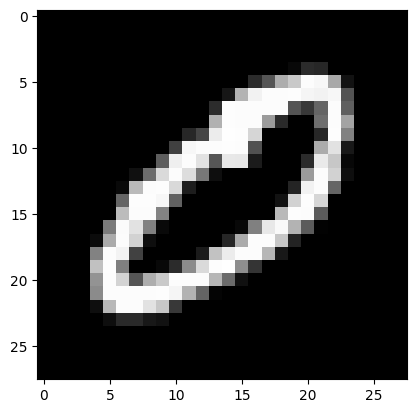

In [27]:
show_image(x, idx=2) # try different indices as well

Now display its reconstruction and compare:

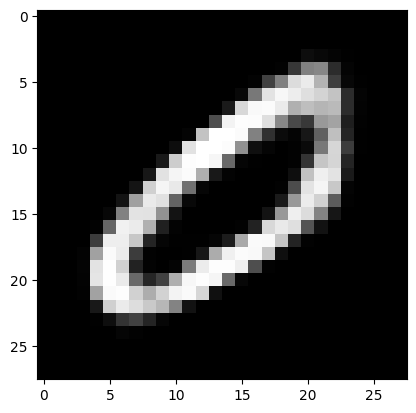

In [28]:
show_image(theta, idx=2)

### ***Step8: Generate images from noise***

In the previous step, we sampled latent vector $z$ from $q(z|x)$. However, we know that the KL term in our loss function enforced $q(z|x)$ to be close to $N(0, I)$. Therefore, we can sample $z$ directly from noise $N(0, I)$, and pass it to the decoder $p(x|z)$.



**Q8.1 (3 points)** Create images from noise and display.

In [31]:
model.eval()
with torch.no_grad():
    eps = torch.randn((batch_size,latent_dim))
    generated_images = model.Decoder(eps)
    print(generated_images.size())
    # insert your code here to create images from noise (it is enough to create theta value for each pixel)
    #
    #
    # generated_images = ....  # should be a matrix ( batch_size-by-x_dim )

torch.Size([100, 784])


Display a couple of generated images:

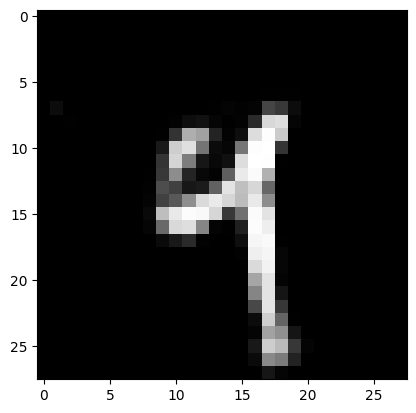

In [35]:

show_image(generated_images, idx=4)

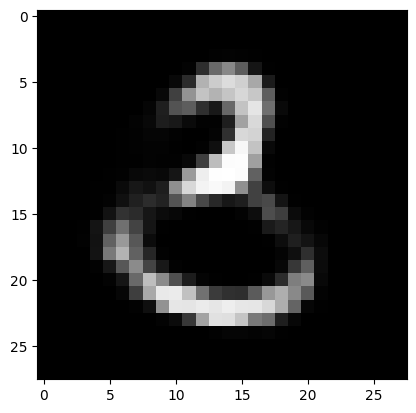

In [37]:
show_image(generated_images, idx=80)

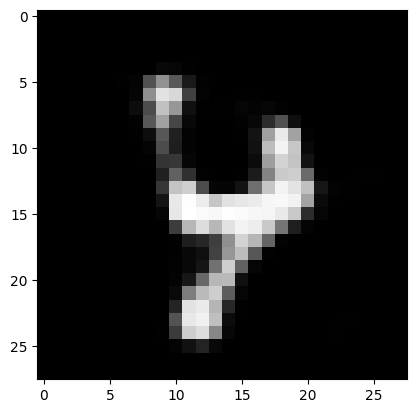

In [38]:
show_image(generated_images, idx=88)